# Auto Encoder Implementation

## Setup and prepare datas

In [1]:
import time
import noise
import imageio
import torch 
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
#from torch.utils.tensorboard import SummaryWriter

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [3]:
# hyperparams
bs=128
step=0
lr=3e-4
num_epochs=30
latent_space=10
criterion=torch.nn.BCELoss()
#writer_tensorboard = SummaryWriter(f"runs/noise")
#writer_tensorboard_denoised = SummaryWriter(f"runs/denoised")

In [4]:
# transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

In [5]:
# load dataset
dset = torchvision.datasets.MNIST(
    root="../gan 2014/data/",
    train=True,
    transform=transform,
    download=True
)

In [6]:
# info 
dset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../gan 2014/data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

/opt/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


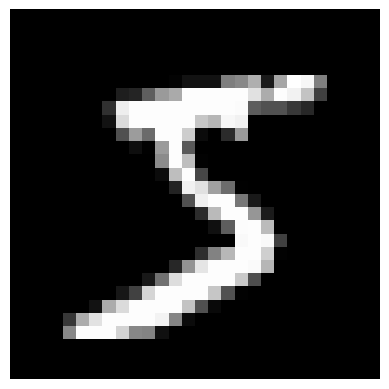

In [7]:
# Plot images
plt.axis('off')
plt.imshow(dset.train_data[0], cmap='gray')
plt.show()

In [8]:
dset_train, y_train = dset.train_data, dset.train_labels # train
dset_test, y_test = dset.test_data, dset.test_labels # test 

/opt/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Add Noise

**Pour les bruits je me suis inspire des bruits utilises dans la capsule fidle pour AE et VAE à savoir :**
- bruit gaussien
- poivre et sel
- bruit loi de poisson
- bruit speckler

In [9]:
noise_image=noise.add_noise(dset_train)# train noise
noise_test=noise.add_noise(dset_test) # test noise

60000it [00:08, 6799.12it/s]


Noise adding sucessfully.


60000it [00:08, 6823.37it/s]

Noise adding sucessfully.


noise_shape: (60000, 28, 28)


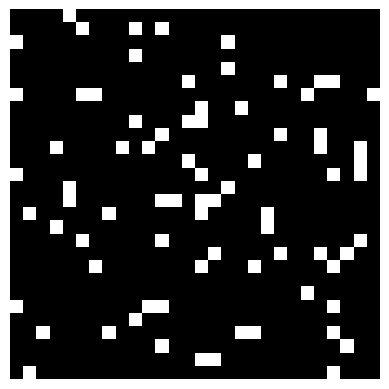

In [10]:
plt.axis('off')
print(f"noise_shape: {noise_image.shape}")
plt.imshow(noise_image[0], cmap='gray')
plt.show()

5it [00:00, 934.19it/s]


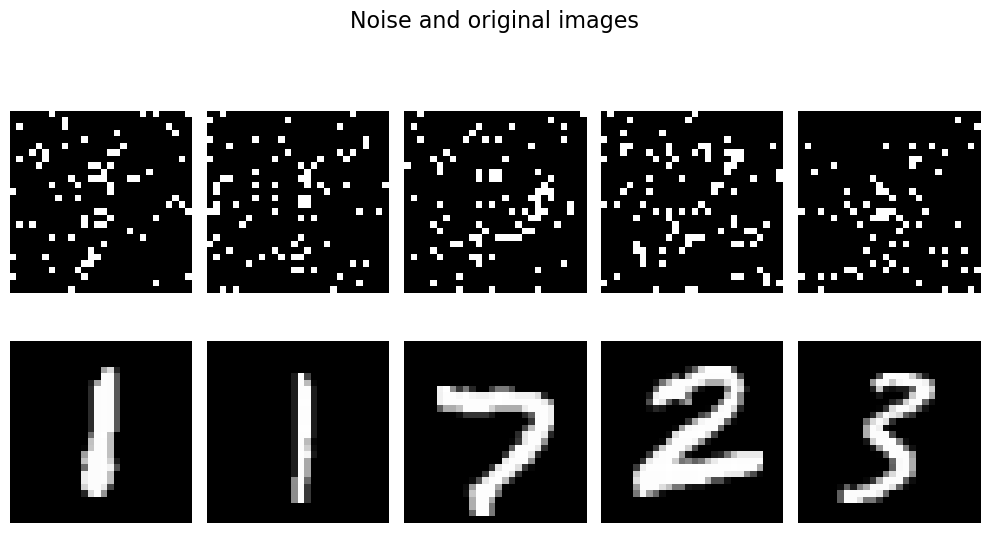

In [11]:
indices = np.random.choice(len(dset_train), 5, replace=False)
fig, axes = plt.subplots(2,5,figsize=(10,6))
fig.suptitle("Noise and original images", fontsize=16)
plt.subplots_adjust(hspace=0.1)


for i, idx in tqdm(enumerate(indices)):
    axes[0,i].imshow(noise_image[idx], cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(dset_train[idx], cmap='gray')
    axes[1,i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
dset_train[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [13]:
#dset_loader = torch.utils.data.DataLoader(dset, batch_size=bs, shuffle=True)
#dset_noise = torch.utils.data.DataLoader(noise_image, batch_size=bs, shuffle=True)

In [14]:
class Data(torch.utils.data.Dataset):
    """
    """
    def __init__(self, data, noise, targets):
        self.data=data
        self.noise=noise
        self.targets=targets
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, x):
        return (
        torch.tensor(self.data[x] / 255.0, dtype=torch.float32), 
        torch.tensor(self.noise[x] / 255.0, dtype=torch.float32), 
        torch.tensor(self.targets[x], dtype=torch.float32)
        )

In [15]:
dset_loader = Data(dset_train, noise_image, y_train) 
dset_loader = torch.utils.data.DataLoader(dset_loader, batch_size=bs, shuffle=True)

dset_test_loader = Data(dset_test, noise_test, y_test)
dset_test_loader=torch.utils.data.DataLoader(dset_test_loader, batch_size=bs, shuffle=True)

## Model

In [16]:
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
        )

        self.latent_space = torch.nn.Linear(64 * 7 * 7, 100)

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid(),
        )
        self.out = torch.nn.Linear(100, 64 * 7 * 7)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28).float()
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.latent_space(x)
        x = self.out(x)
        x = x.view(x.size(0), 64, 7, 7)
        x = self.decoder(x)
        return x

In [17]:
ae_denoised = ConvAutoencoder().to(device)
opt=torch.optim.Adam(ae_denoised.parameters(), lr=3e-4)
ae_denoised

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (latent_space): Linear(in_features=3136, out_features=100, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
  (out): Linear(in_features=100, out_features=3136, bias=True)
)

In [18]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    ae_denoised.train()
    train_losses = []
    test_losses=[]
    epoch_loss = 0
    for clean_imgs, noisy_imgs, target in dset_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device).unsqueeze(1)
        outputs = ae_denoised(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(dset_loader))
    
    ae_denoised.eval()
    test_loss = 0
    
    with torch.no_grad():
        for clean_imgs, noisy_imgs, target in dset_test_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device).unsqueeze(1)
            outputs = ae_denoised(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            test_loss += loss.item()
    test_losses.append(test_loss / len(dset_test_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')  

  0%|          | 0/30 [00:00<?, ?it/s]/var/folders/2k/078ng9w935bc_wvxlwg1z_rm0000gn/T/ipykernel_20916/10343886.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.data[x] / 255.0, dtype=torch.float32),
/var/folders/2k/078ng9w935bc_wvxlwg1z_rm0000gn/T/ipykernel_20916/10343886.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.targets[x], dtype=torch.float32)
  3%|▎         | 1/30 [00:14<06:59, 14.47s/it]

Epoch 1/30, Train Loss: 0.2911, Test Loss: 0.2633


  7%|▋         | 2/30 [00:24<05:27, 11.69s/it]

Epoch 2/30, Train Loss: 0.2633, Test Loss: 0.2632


 10%|█         | 3/30 [00:34<04:53, 10.87s/it]

Epoch 3/30, Train Loss: 0.2633, Test Loss: 0.2633


 13%|█▎        | 4/30 [00:43<04:31, 10.44s/it]

Epoch 4/30, Train Loss: 0.2632, Test Loss: 0.2632


 17%|█▋        | 5/30 [00:53<04:15, 10.20s/it]

Epoch 5/30, Train Loss: 0.2631, Test Loss: 0.2631


 20%|██        | 6/30 [01:03<04:01, 10.07s/it]

Epoch 6/30, Train Loss: 0.2631, Test Loss: 0.2632


 23%|██▎       | 7/30 [01:13<03:50, 10.03s/it]

Epoch 7/30, Train Loss: 0.2630, Test Loss: 0.2634


 27%|██▋       | 8/30 [01:23<03:39,  9.97s/it]

Epoch 8/30, Train Loss: 0.2628, Test Loss: 0.2624


 30%|███       | 9/30 [01:32<03:27,  9.87s/it]

Epoch 9/30, Train Loss: 0.2593, Test Loss: 0.2510


 33%|███▎      | 10/30 [01:42<03:16,  9.80s/it]

Epoch 10/30, Train Loss: 0.2369, Test Loss: 0.2268


 37%|███▋      | 11/30 [01:52<03:05,  9.78s/it]

Epoch 11/30, Train Loss: 0.2214, Test Loss: 0.2169


 40%|████      | 12/30 [02:02<02:57,  9.84s/it]

Epoch 12/30, Train Loss: 0.2146, Test Loss: 0.2121


 43%|████▎     | 13/30 [02:11<02:46,  9.79s/it]

Epoch 13/30, Train Loss: 0.2100, Test Loss: 0.2082


 47%|████▋     | 14/30 [02:21<02:35,  9.74s/it]

Epoch 14/30, Train Loss: 0.2062, Test Loss: 0.2051


 50%|█████     | 15/30 [02:31<02:26,  9.74s/it]

Epoch 15/30, Train Loss: 0.2036, Test Loss: 0.2029


 53%|█████▎    | 16/30 [02:40<02:16,  9.72s/it]

Epoch 16/30, Train Loss: 0.2015, Test Loss: 0.2007


 57%|█████▋    | 17/30 [02:50<02:06,  9.73s/it]

Epoch 17/30, Train Loss: 0.1999, Test Loss: 0.1989


 60%|██████    | 18/30 [03:00<01:56,  9.72s/it]

Epoch 18/30, Train Loss: 0.1984, Test Loss: 0.1977


 63%|██████▎   | 19/30 [03:10<01:46,  9.72s/it]

Epoch 19/30, Train Loss: 0.1972, Test Loss: 0.1966


 67%|██████▋   | 20/30 [03:19<01:37,  9.73s/it]

Epoch 20/30, Train Loss: 0.1961, Test Loss: 0.1956


 70%|███████   | 21/30 [03:29<01:27,  9.72s/it]

Epoch 21/30, Train Loss: 0.1951, Test Loss: 0.1947


 73%|███████▎  | 22/30 [03:39<01:17,  9.71s/it]

Epoch 22/30, Train Loss: 0.1943, Test Loss: 0.1941


 77%|███████▋  | 23/30 [03:48<01:07,  9.68s/it]

Epoch 23/30, Train Loss: 0.1936, Test Loss: 0.1934


 80%|████████  | 24/30 [03:58<00:58,  9.68s/it]

Epoch 24/30, Train Loss: 0.1929, Test Loss: 0.1931


 83%|████████▎ | 25/30 [04:08<00:48,  9.67s/it]

Epoch 25/30, Train Loss: 0.1923, Test Loss: 0.1923


 87%|████████▋ | 26/30 [04:17<00:38,  9.70s/it]

Epoch 26/30, Train Loss: 0.1916, Test Loss: 0.1918


 90%|█████████ | 27/30 [04:27<00:29,  9.70s/it]

Epoch 27/30, Train Loss: 0.1911, Test Loss: 0.1917


 93%|█████████▎| 28/30 [04:37<00:19,  9.68s/it]

Epoch 28/30, Train Loss: 0.1907, Test Loss: 0.1910


 97%|█████████▋| 29/30 [04:47<00:09,  9.68s/it]

Epoch 29/30, Train Loss: 0.1901, Test Loss: 0.1907


100%|██████████| 30/30 [04:56<00:00,  9.89s/it]

Epoch 30/30, Train Loss: 0.1898, Test Loss: 0.1907


## Evaluation

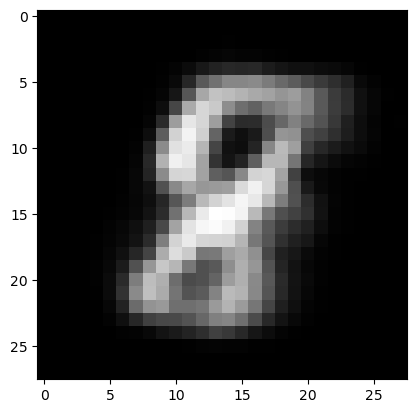

In [19]:
# check fast denoising on train set 
z = outputs[5].detach().cpu().numpy()
plt.imshow(z[0], cmap='gray')
plt.show()

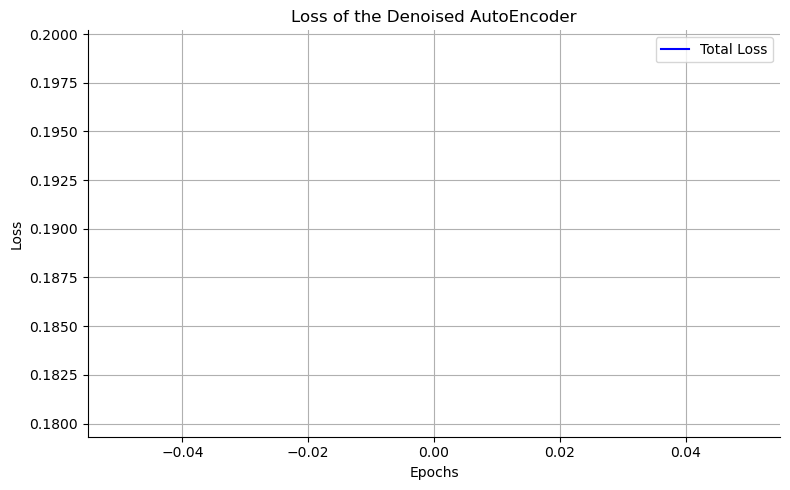

In [20]:
plt.figure(figsize=(8, 5))
plt.title("Loss of the Denoised AutoEncoder")
plt.plot(train_losses, label='Total Loss', color='blue')

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.legend(loc='upper right')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

5it [00:00,  8.26it/s]


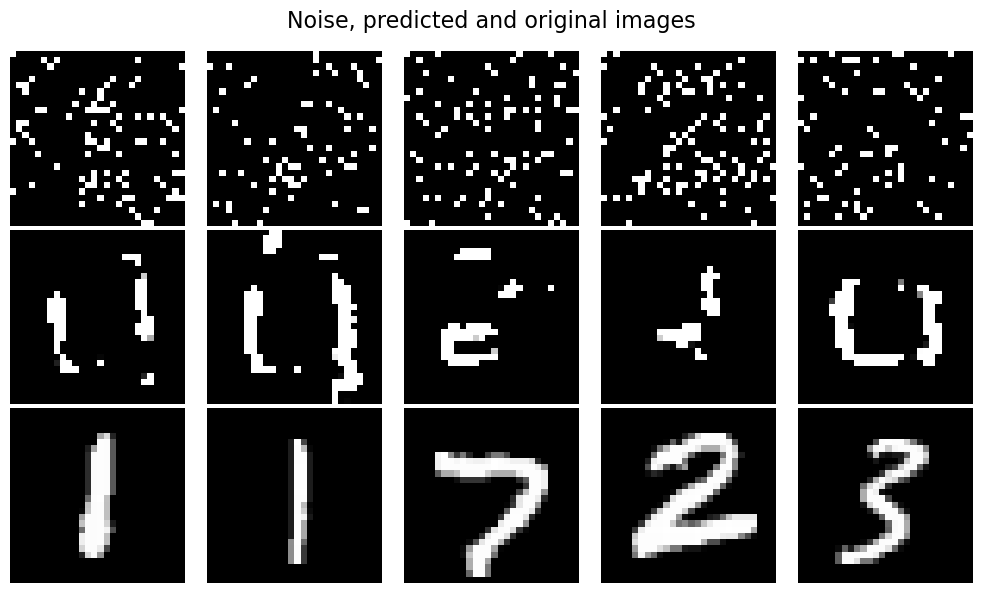

In [21]:
ae_denoised.eval()
with torch.no_grad():
    eval=ae_denoised(dset_test.to(device))
#indices = np.random.choice(len(dset_test), 5, replace=False)
fig, axes = plt.subplots(3,5,figsize=(10,6))
fig.suptitle("Noise, predicted and original images", fontsize=16)
plt.subplots_adjust(hspace=0.1)


for i, idx in tqdm(enumerate(indices)):
    eval_img=eval[idx].detach().cpu().numpy()
    axes[0,i].imshow(noise_test[idx], cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(eval_img.squeeze(0), cmap='gray')
    axes[1,i].axis('off')
    axes[2,i].imshow(dset_test[idx], cmap='gray')
    axes[2,i].axis('off')

plt.tight_layout()
plt.show()

(1, 28, 28)


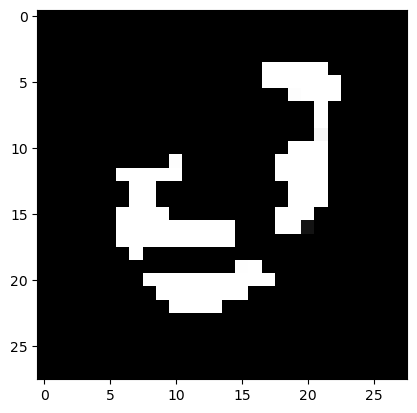

In [22]:
e=ae_denoised(dset_test.to(device))
e=e[0].detach().cpu().numpy()
print(e.shape)
plt.imshow(e.squeeze(0), cmap='gray')

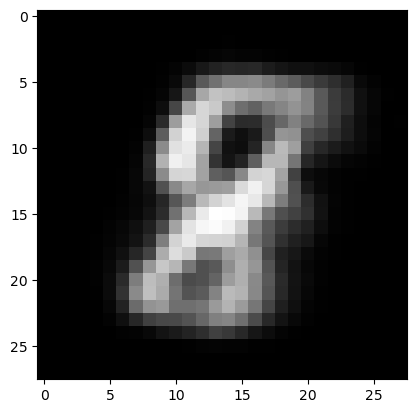

In [23]:
z = outputs[5].detach().cpu().numpy()
plt.imshow(z[0], cmap='gray')
plt.show()
